In [1]:
import os, sys
cwd = os.getcwd()
module_path = os.path.dirname(cwd)  # target working directory

sys.path = [item for item in sys.path if item != module_path]  # remove module_path from sys.path
sys.path.append(module_path)  # add module_path to sys.path

import os
import glob
import numpy as np
import time
import librosa
import pandas as pd
import seaborn as sns

from joblib import dump, load

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils.fixes import loguniform
from scipy import sparse
from scipy.stats import uniform
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid, cross_validate
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import make_scorer, zero_one_loss, ConfusionMatrixDisplay
from pyrcn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from pyrcn.model_selection import SequentialSearchCV
from pyrcn.util import FeatureExtractor
from pyrcn.datasets import fetch_ptdb_tug_dataset
from pyrcn.echo_state_network import SeqToLabelESNClassifier
from pyrcn.base.blocks import InputToNode, PredefinedWeightsInputToNode, NodeToNode, PredefinedWeightsNodeToNode

import matplotlib as mpl
from matplotlib import ticker
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex': True,
          'font.size': 8,
          'font.family': 'lmodern',
         }
plt.rcParams.update(params)
plt.rc('image', cmap='RdBu')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rc('font', **{'family': 'serif'})
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from mpl_toolkits.axes_grid1 import make_axes_locatable

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


In [2]:
all_files = glob.glob(r"E:\free-spoken-digit-dataset\recordings\*.wav")
print(len(all_files))

3000


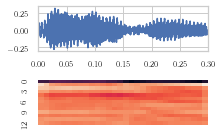

In [3]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=60, n_mfcc=13)
# X = np.vstack((mfcc, mfcc_delta, mfcc_delta2))
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

fig, axs = plt.subplots(2, 1)
fig.set_size_inches(3.2, 2)

sns.lineplot(x=t, y=x, ax=axs[0])
axs[0].set(xlim=(0, 0.3))
sns.heatmap(data=X.T, ax=axs[1], xticklabels=np.arange(X.shape[0]) / 100, cbar=False)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(10))

"""
axs[0].plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(2, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
"""
plt.tight_layout()

In [4]:
X_train = []
X_test = []
y_train = []
y_test = []
print("extracting features...")
for k, f in enumerate(all_files):
    basename = os.path.basename(f).split('.')[0]
    # Get label (0-9) of recording.
    label = int(basename.split('_')[0])
    idx = int(basename.split('_')[2])
    # Load the audio signal and normalize it.
    x, sr = librosa.core.load(f, sr=None, mono=False)
    # x /= np.max(np.abs(x))
    mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=60, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    if idx <= 4:
        X_test.append(mfcc.T)
        y_test.append(label)
    else:
        X_train.append(mfcc.T)
        y_train.append(label)
print("done!")
X_train, y_train = shuffle(X_train, y_train, random_state=0)

extracting features...
done!


In [5]:
scaler = StandardScaler().fit(X=np.vstack(X_train + X_test))
X_train_scaled = np.empty(shape=(len(X_train),), dtype=object)
X_test_scaled = np.empty(shape=(len(X_test),), dtype=object)
y_train = np.array(y_train, dtype=object)
y_test = np.array(y_test, dtype=object)
for k in range(len(X_train)):
    X_train_scaled[k] = scaler.transform(X_train[k])
    y_train[k] = np.atleast_1d(y_train[k]).astype(int)
for k in range(len(X_test)):
    X_test_scaled[k] = scaler.transform(X_test[k])
    y_test[k] = np.atleast_1d(y_test[k]).astype(int)

In [6]:
print(len(X_train), len(y_train), X_train[0].shape, y_train[0])
print(len(X_test), len(y_test), X_test[0].shape, y_test[0])

2700 2700 (37, 13) [8]
300 300 (30, 13) [0]


# Basic ESN

In [7]:
initially_fixed_params = {'hidden_layer_size': 50,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 1.0,
                          'leakage': 0.1,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bi_directional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-5,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': loguniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3)]

base_esn = SeqToLabelESNClassifier(**initially_fixed_params)

try:
    sequential_search = load("../sequential_search_fsdd_random.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train_scaled, y_train)
    dump(sequential_search, "../sequential_search_fsdd_random.joblib")

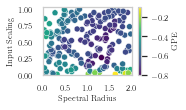

In [8]:
df = pd.DataFrame(sequential_search.all_cv_results_["step1"])
df["mean_test_score"] = -df["mean_test_score"]
# df.mean_test_score = df.mean_test_score.clip(upper=1.5e-1)
fig = plt.figure()
ax = sns.scatterplot(x="param_spectral_radius", y="param_input_scaling", hue="mean_test_score", palette='viridis', data=df)
plt.xlabel("Spectral Radius")
plt.ylabel("Input Scaling")

norm = plt.Normalize(-0.8, -0.1)
# sm = plt.cm.ScalarMappable(cmap="viridis")
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
plt.xlim((0, 2.01))
plt.ylim((0, 1.03))

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='GPE')
fig.set_size_inches(2, 1.25)
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.grid()
# plt.savefig('optimize_is_sr_50.pdf', bbox_inches='tight', pad_inches=0)

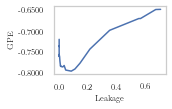

In [9]:
df = pd.DataFrame(sequential_search.all_cv_results_["step2"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_leakage", y="mean_test_score")
plt.xlabel("Leakage")
plt.ylabel("GPE")
# plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.grid()
# plt.savefig('optimize_leakage_50.pdf', bbox_inches='tight', pad_inches=0)

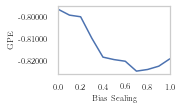

In [10]:
df = pd.DataFrame(sequential_search.all_cv_results_["step3"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score")
plt.xlabel("Bias Scaling")
plt.ylabel("GPE")
plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
plt.grid()
# plt.savefig('optimize_bias_scaling_50.pdf', bbox_inches='tight', pad_inches=0)

K-Means training and transition matrix

In [11]:
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = np.zeros(shape=(n,n))

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

kmeans = MiniBatchKMeans(n_clusters=50, n_init=200, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=2, random_state=0)
kmeans.fit(X=np.concatenate(np.concatenate((X_train, X_test))))
w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
input_to_node = PredefinedWeightsInputToNode(predefined_input_weights=w_in.T)
w_rec = transition_matrix(kmeans.labels_)
node_to_node = PredefinedWeightsNodeToNode(predefined_recurrent_weights=w_rec)
node_to_node_eig = PredefinedWeightsNodeToNode(predefined_recurrent_weights=w_rec / np.max(np.abs(np.linalg.eigvals(w_rec))))

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Init 1/200 with method: k-means++
Inertia for init 1/200: 425118.312500
Init 2/200 with method: k-means++
Inertia for init 2/200: 453357.687500
Init 3/200 with method: k-means++
Inertia for init 3/200: 445595.156250
Init 4/200 with method: k-means++
Inertia for init 4/200: 447586.187500
Init 5/200 with method: k-means++
Inertia for init 5/200: 454940.187500
Init 6/200 with method: k-means++
Inertia for init 6/200: 460890.875000
Init 7/200 with method: k-means++
Inertia for init 7/200: 458290.500000
Init 8/200 with method: k-means++
Inertia for init 8/200: 445765.406250
Init 9/200 with method: k-means++
Inertia for init 9/200: 450395.656250
Init 10/200 with method: k-means++
Inertia for init 10/200: 442162.875000
Init 11/200 with method: k-means++
Inertia for init 11/200: 459964.218750
Init 12/200 with method: k-means++
Inertia for init 12/200: 452768.187500
Init 13/200 with method: k-means++
Inertia for init 13/200: 445763.656250
Init 14/200 with method: k-means++
Inertia for init 14/2

Minibatch iteration 16/132800: mean batch inertia: 1643.569062, ewa inertia: 1834.867939 
Minibatch iteration 17/132800: mean batch inertia: 1867.785000, ewa inertia: 1834.917531 
Minibatch iteration 18/132800: mean batch inertia: 1682.776094, ewa inertia: 1834.688317 
Minibatch iteration 19/132800: mean batch inertia: 1752.556250, ewa inertia: 1834.564579 
Minibatch iteration 20/132800: mean batch inertia: 1577.163125, ewa inertia: 1834.176783 
Minibatch iteration 21/132800: mean batch inertia: 1705.587031, ewa inertia: 1833.983052 
Minibatch iteration 22/132800: mean batch inertia: 1845.647344, ewa inertia: 1834.000626 
Minibatch iteration 23/132800: mean batch inertia: 1737.987344, ewa inertia: 1833.855974 
Minibatch iteration 24/132800: mean batch inertia: 1638.020469, ewa inertia: 1833.560932 
Minibatch iteration 25/132800: mean batch inertia: 1666.312500, ewa inertia: 1833.308959 
Minibatch iteration 26/132800: mean batch inertia: 1784.047969, ewa inertia: 1833.234743 
Minibatch 

Minibatch iteration 196/132800: mean batch inertia: 1613.350000, ewa inertia: 1794.305748 
Minibatch iteration 197/132800: mean batch inertia: 1743.385313, ewa inertia: 1794.229033 
Minibatch iteration 198/132800: mean batch inertia: 1711.327812, ewa inertia: 1794.104135 
Minibatch iteration 199/132800: mean batch inertia: 1578.753438, ewa inertia: 1793.779692 
Minibatch iteration 200/132800: mean batch inertia: 1861.674062, ewa inertia: 1793.881981 
Minibatch iteration 201/132800: mean batch inertia: 1591.661875, ewa inertia: 1793.577320 
Minibatch iteration 202/132800: mean batch inertia: 1529.795156, ewa inertia: 1793.179911 
Minibatch iteration 203/132800: mean batch inertia: 1542.677031, ewa inertia: 1792.802508 
Minibatch iteration 204/132800: mean batch inertia: 1701.530469, ewa inertia: 1792.665000 
Minibatch iteration 205/132800: mean batch inertia: 1717.567656, ewa inertia: 1792.551860 
Minibatch iteration 206/132800: mean batch inertia: 1819.790156, ewa inertia: 1792.592896 

Minibatch iteration 376/132800: mean batch inertia: 1566.732031, ewa inertia: 1760.399457 
Minibatch iteration 377/132800: mean batch inertia: 1545.668125, ewa inertia: 1760.075947 
Minibatch iteration 378/132800: mean batch inertia: 1552.724219, ewa inertia: 1759.763555 
Minibatch iteration 379/132800: mean batch inertia: 1787.680156, ewa inertia: 1759.805613 
Minibatch iteration 380/132800: mean batch inertia: 1728.773906, ewa inertia: 1759.758862 
Minibatch iteration 381/132800: mean batch inertia: 1750.502969, ewa inertia: 1759.744917 
Minibatch iteration 382/132800: mean batch inertia: 1712.559531, ewa inertia: 1759.673828 
Minibatch iteration 383/132800: mean batch inertia: 1608.557188, ewa inertia: 1759.446159 
Minibatch iteration 384/132800: mean batch inertia: 1500.718281, ewa inertia: 1759.056365 
Minibatch iteration 385/132800: mean batch inertia: 1790.991719, ewa inertia: 1759.104478 
Minibatch iteration 386/132800: mean batch inertia: 1673.316719, ewa inertia: 1758.975232 

Minibatch iteration 556/132800: mean batch inertia: 1637.821406, ewa inertia: 1733.540135 
Minibatch iteration 557/132800: mean batch inertia: 1644.051563, ewa inertia: 1733.405313 
Minibatch iteration 558/132800: mean batch inertia: 1586.639375, ewa inertia: 1733.184199 
Minibatch iteration 559/132800: mean batch inertia: 1574.162969, ewa inertia: 1732.944620 
Minibatch iteration 560/132800: mean batch inertia: 1648.649688, ewa inertia: 1732.817623 
Minibatch iteration 561/132800: mean batch inertia: 1693.686875, ewa inertia: 1732.758670 
Minibatch iteration 562/132800: mean batch inertia: 1647.427969, ewa inertia: 1732.630112 
Minibatch iteration 563/132800: mean batch inertia: 1577.667187, ewa inertia: 1732.396648 
Minibatch iteration 564/132800: mean batch inertia: 1752.121406, ewa inertia: 1732.426365 
Minibatch iteration 565/132800: mean batch inertia: 1600.579219, ewa inertia: 1732.227727 
Minibatch iteration 566/132800: mean batch inertia: 1643.192188, ewa inertia: 1732.093588 

Minibatch iteration 736/132800: mean batch inertia: 1701.067969, ewa inertia: 1710.536260 
Minibatch iteration 737/132800: mean batch inertia: 1722.105469, ewa inertia: 1710.553690 
Minibatch iteration 738/132800: mean batch inertia: 1589.377656, ewa inertia: 1710.371129 
Minibatch iteration 739/132800: mean batch inertia: 1765.694062, ewa inertia: 1710.454477 
Minibatch iteration 740/132800: mean batch inertia: 1642.218281, ewa inertia: 1710.351674 
Minibatch iteration 741/132800: mean batch inertia: 1579.971406, ewa inertia: 1710.155246 
Minibatch iteration 742/132800: mean batch inertia: 1429.911094, ewa inertia: 1709.733036 
Minibatch iteration 743/132800: mean batch inertia: 1464.947500, ewa inertia: 1709.364247 
Minibatch iteration 744/132800: mean batch inertia: 1636.659844, ewa inertia: 1709.254712 
Minibatch iteration 745/132800: mean batch inertia: 1678.707344, ewa inertia: 1709.208690 
Minibatch iteration 746/132800: mean batch inertia: 1726.765938, ewa inertia: 1709.235141 

Minibatch iteration 916/132800: mean batch inertia: 1712.743281, ewa inertia: 1690.581396 
Minibatch iteration 917/132800: mean batch inertia: 1651.271250, ewa inertia: 1690.522172 
Minibatch iteration 918/132800: mean batch inertia: 1587.408281, ewa inertia: 1690.366823 
Minibatch iteration 919/132800: mean batch inertia: 1734.993125, ewa inertia: 1690.434056 
Minibatch iteration 920/132800: mean batch inertia: 1562.093125, ewa inertia: 1690.240700 
Minibatch iteration 921/132800: mean batch inertia: 1598.334375, ewa inertia: 1690.102236 
Minibatch iteration 922/132800: mean batch inertia: 1831.104844, ewa inertia: 1690.314668 
Minibatch iteration 923/132800: mean batch inertia: 1533.979687, ewa inertia: 1690.079136 
Minibatch iteration 924/132800: mean batch inertia: 1434.784844, ewa inertia: 1689.694515 
Minibatch iteration 925/132800: mean batch inertia: 1757.425000, ewa inertia: 1689.796557 
Minibatch iteration 926/132800: mean batch inertia: 1765.608281, ewa inertia: 1689.910773 

Minibatch iteration 1094/132800: mean batch inertia: 1651.851562, ewa inertia: 1676.271538 
Minibatch iteration 1095/132800: mean batch inertia: 1647.533594, ewa inertia: 1676.228242 
Minibatch iteration 1096/132800: mean batch inertia: 1769.519375, ewa inertia: 1676.368793 
Minibatch iteration 1097/132800: mean batch inertia: 1514.960469, ewa inertia: 1676.125618 
Minibatch iteration 1098/132800: mean batch inertia: 1624.384531, ewa inertia: 1676.047666 
Minibatch iteration 1099/132800: mean batch inertia: 1732.876719, ewa inertia: 1676.133284 
Minibatch iteration 1100/132800: mean batch inertia: 1692.075625, ewa inertia: 1676.157302 
Minibatch iteration 1101/132800: mean batch inertia: 1542.729063, ewa inertia: 1675.956282 
Minibatch iteration 1102/132800: mean batch inertia: 1514.142969, ewa inertia: 1675.712497 
Minibatch iteration 1103/132800: mean batch inertia: 1694.249687, ewa inertia: 1675.740425 
Minibatch iteration 1104/132800: mean batch inertia: 1519.052656, ewa inertia: 1

Minibatch iteration 1272/132800: mean batch inertia: 1620.339844, ewa inertia: 1666.356091 
Minibatch iteration 1273/132800: mean batch inertia: 1654.772656, ewa inertia: 1666.338639 
Minibatch iteration 1274/132800: mean batch inertia: 1677.580625, ewa inertia: 1666.355576 
Minibatch iteration 1275/132800: mean batch inertia: 1696.998906, ewa inertia: 1666.401743 
Minibatch iteration 1276/132800: mean batch inertia: 1729.512813, ewa inertia: 1666.496825 
Minibatch iteration 1277/132800: mean batch inertia: 1704.798594, ewa inertia: 1666.554529 
Minibatch iteration 1278/132800: mean batch inertia: 1699.638125, ewa inertia: 1666.604372 
Minibatch iteration 1279/132800: mean batch inertia: 1571.828594, ewa inertia: 1666.461585 
Minibatch iteration 1280/132800: mean batch inertia: 1678.512500, ewa inertia: 1666.479741 
Minibatch iteration 1281/132800: mean batch inertia: 1648.730781, ewa inertia: 1666.453001 
Minibatch iteration 1282/132800: mean batch inertia: 1547.917500, ewa inertia: 1

Minibatch iteration 1450/132800: mean batch inertia: 1441.208437, ewa inertia: 1657.197381 
Minibatch iteration 1451/132800: mean batch inertia: 1715.853594, ewa inertia: 1657.285751 
Minibatch iteration 1452/132800: mean batch inertia: 1778.523906, ewa inertia: 1657.468406 
Minibatch iteration 1453/132800: mean batch inertia: 1707.524219, ewa inertia: 1657.543819 
Minibatch iteration 1454/132800: mean batch inertia: 1529.908281, ewa inertia: 1657.351526 
Minibatch iteration 1455/132800: mean batch inertia: 1524.609375, ewa inertia: 1657.151539 
Minibatch iteration 1456/132800: mean batch inertia: 1527.400469, ewa inertia: 1656.956059 
Minibatch iteration 1457/132800: mean batch inertia: 1531.874219, ewa inertia: 1656.767613 
Minibatch iteration 1458/132800: mean batch inertia: 1684.048594, ewa inertia: 1656.808714 
Minibatch iteration 1459/132800: mean batch inertia: 1504.588750, ewa inertia: 1656.579383 
Minibatch iteration 1460/132800: mean batch inertia: 1663.188437, ewa inertia: 1

Minibatch iteration 1628/132800: mean batch inertia: 1589.753594, ewa inertia: 1650.207179 
Minibatch iteration 1629/132800: mean batch inertia: 1732.867969, ewa inertia: 1650.331714 
Minibatch iteration 1630/132800: mean batch inertia: 1619.866406, ewa inertia: 1650.285815 
Minibatch iteration 1631/132800: mean batch inertia: 1807.307812, ewa inertia: 1650.522382 
Minibatch iteration 1632/132800: mean batch inertia: 1722.805781, ewa inertia: 1650.631282 
Minibatch iteration 1633/132800: mean batch inertia: 1658.387031, ewa inertia: 1650.642967 
Minibatch iteration 1634/132800: mean batch inertia: 1551.391250, ewa inertia: 1650.493436 
Minibatch iteration 1635/132800: mean batch inertia: 1742.412812, ewa inertia: 1650.631920 
Minibatch iteration 1636/132800: mean batch inertia: 1640.801563, ewa inertia: 1650.617110 
Minibatch iteration 1637/132800: mean batch inertia: 1592.034844, ewa inertia: 1650.528851 
Minibatch iteration 1638/132800: mean batch inertia: 1626.206250, ewa inertia: 1

Minibatch iteration 1806/132800: mean batch inertia: 1896.661094, ewa inertia: 1645.273131 
Minibatch iteration 1807/132800: mean batch inertia: 1556.559219, ewa inertia: 1645.139476 
Minibatch iteration 1808/132800: mean batch inertia: 1629.634531, ewa inertia: 1645.116117 
Minibatch iteration 1809/132800: mean batch inertia: 1587.899688, ewa inertia: 1645.029916 
Minibatch iteration 1810/132800: mean batch inertia: 1634.117188, ewa inertia: 1645.013475 
Minibatch iteration 1811/132800: mean batch inertia: 1663.965156, ewa inertia: 1645.042027 
Minibatch iteration 1812/132800: mean batch inertia: 1790.613906, ewa inertia: 1645.261343 
Minibatch iteration 1813/132800: mean batch inertia: 1706.487031, ewa inertia: 1645.353584 
Minibatch iteration 1814/132800: mean batch inertia: 1641.108750, ewa inertia: 1645.347189 
Minibatch iteration 1815/132800: mean batch inertia: 1654.074063, ewa inertia: 1645.360337 
Minibatch iteration 1816/132800: mean batch inertia: 1601.911406, ewa inertia: 1

# KM-ESN

In [12]:
initially_fixed_params = {'hidden_layer_size': 50,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 1.0,
                          'leakage': 0.1,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bi_directional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-5,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': loguniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3)]

base_esn = SeqToLabelESNClassifier(input_to_node=input_to_node).set_params(**initially_fixed_params)

try:
    sequential_search = load("../sequential_search_fsdd_kmeans.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train_scaled, y_train)
    dump(sequential_search, "../sequential_search_fsdd_kmeans.joblib")

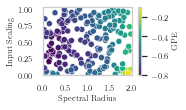

In [13]:
df = pd.DataFrame(sequential_search.all_cv_results_["step1"])
df["mean_test_score"] = -df["mean_test_score"]
# df.mean_test_score = df.mean_test_score.clip(upper=1.5e-1)
fig = plt.figure()
ax = sns.scatterplot(x="param_spectral_radius", y="param_input_scaling", hue="mean_test_score", palette='viridis', data=df)
plt.xlabel("Spectral Radius")
plt.ylabel("Input Scaling")

norm = plt.Normalize(-0.8, -0.1)
# sm = plt.cm.ScalarMappable(cmap="viridis")
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
plt.xlim((0, 2.01))
plt.ylim((0, 1.03))

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='GPE')
fig.set_size_inches(2, 1.25)
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.grid()
# plt.savefig('optimize_is_sr_50.pdf', bbox_inches='tight', pad_inches=0)

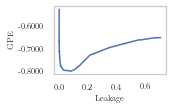

In [14]:
df = pd.DataFrame(sequential_search.all_cv_results_["step2"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_leakage", y="mean_test_score")
plt.xlabel("Leakage")
plt.ylabel("GPE")
# plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.grid()
# plt.savefig('optimize_leakage_50.pdf', bbox_inches='tight', pad_inches=0)

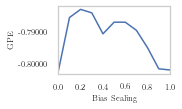

In [15]:
df = pd.DataFrame(sequential_search.all_cv_results_["step3"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score")
plt.xlabel("Bias Scaling")
plt.ylabel("GPE")
plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
plt.grid()
# plt.savefig('optimize_bias_scaling_50.pdf', bbox_inches='tight', pad_inches=0)

# KM-ESN with transition matrix

In [16]:
initially_fixed_params = {'hidden_layer_size': 50,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 1.0,
                          'leakage': 0.1,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bi_directional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-5,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': loguniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3)]

base_esn = SeqToLabelESNClassifier(input_to_node=input_to_node, 
                                   node_to_node=node_to_node).set_params(**initially_fixed_params)

try:
    sequential_search = load("../sequential_search_fsdd_kmeans_rec.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train_scaled, y_train)
    dump(sequential_search, "../sequential_search_fsdd_kmeans_rec.joblib")

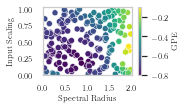

In [17]:
df = pd.DataFrame(sequential_search.all_cv_results_["step1"])
df["mean_test_score"] = -df["mean_test_score"]
# df.mean_test_score = df.mean_test_score.clip(upper=1.5e-1)
fig = plt.figure()
ax = sns.scatterplot(x="param_spectral_radius", y="param_input_scaling", hue="mean_test_score", palette='viridis', data=df)
plt.xlabel("Spectral Radius")
plt.ylabel("Input Scaling")

norm = plt.Normalize(-0.8, -0.1)
# sm = plt.cm.ScalarMappable(cmap="viridis")
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
plt.xlim((0, 2.01))
plt.ylim((0, 1.03))

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='GPE')
fig.set_size_inches(2, 1.25)
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.grid()
# plt.savefig('optimize_is_sr_50.pdf', bbox_inches='tight', pad_inches=0)

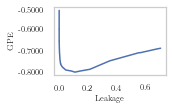

In [18]:
df = pd.DataFrame(sequential_search.all_cv_results_["step2"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_leakage", y="mean_test_score")
plt.xlabel("Leakage")
plt.ylabel("GPE")
# plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.grid()
# plt.savefig('optimize_leakage_50.pdf', bbox_inches='tight', pad_inches=0)

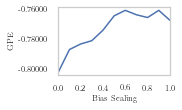

In [19]:
df = pd.DataFrame(sequential_search.all_cv_results_["step3"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score")
plt.xlabel("Bias Scaling")
plt.ylabel("GPE")
plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
plt.grid()
# plt.savefig('optimize_bias_scaling_50.pdf', bbox_inches='tight', pad_inches=0)

# KM-ESN with normalized transition matrix

In [20]:
initially_fixed_params = {'hidden_layer_size': 50,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 1.0,
                          'leakage': 0.1,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bi_directional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-5,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': loguniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3)]

base_esn = SeqToLabelESNClassifier(input_to_node=input_to_node, 
                                   node_to_node=node_to_node_eig).set_params(**initially_fixed_params)

try:
    sequential_search = load("../sequential_search_fsdd_kmeans_rec_eigs.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train_scaled, y_train)
    dump(sequential_search, "../sequential_search_fsdd_kmeans_rec_eigs.joblib")

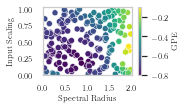

In [21]:
df = pd.DataFrame(sequential_search.all_cv_results_["step1"])
df["mean_test_score"] = -df["mean_test_score"]
# df.mean_test_score = df.mean_test_score.clip(upper=1.5e-1)
fig = plt.figure()
ax = sns.scatterplot(x="param_spectral_radius", y="param_input_scaling", hue="mean_test_score", palette='viridis', data=df)
plt.xlabel("Spectral Radius")
plt.ylabel("Input Scaling")

norm = plt.Normalize(-0.8, -0.1)
# sm = plt.cm.ScalarMappable(cmap="viridis")
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
plt.xlim((0, 2.01))
plt.ylim((0, 1.03))

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='GPE')
fig.set_size_inches(2, 1.25)
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.grid()
# plt.savefig('optimize_is_sr_50.pdf', bbox_inches='tight', pad_inches=0)

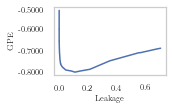

In [22]:
df = pd.DataFrame(sequential_search.all_cv_results_["step2"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_leakage", y="mean_test_score")
plt.xlabel("Leakage")
plt.ylabel("GPE")
# plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.grid()
# plt.savefig('optimize_leakage_50.pdf', bbox_inches='tight', pad_inches=0)

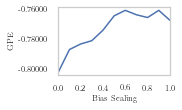

In [23]:
df = pd.DataFrame(sequential_search.all_cv_results_["step3"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score")
plt.xlabel("Bias Scaling")
plt.ylabel("GPE")
plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
plt.grid()
# plt.savefig('optimize_bias_scaling_50.pdf', bbox_inches='tight', pad_inches=0)

# Weight visualization

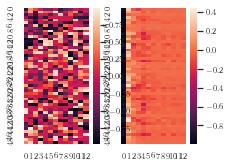

In [35]:
fig, axs = plt.subplots(1, 2)

# TODO: Plot the input weights
sns.heatmap(load("../sequential_search_fsdd_random.joblib").best_estimator_.input_to_node.input_weights.todense().T, ax=axs[0])
sns.heatmap(load("../sequential_search_fsdd_kmeans.joblib").best_estimator_.input_to_node.input_weights.T, ax=axs[1])
fig.set_size_inches(3.2, 2.5)
plt.savefig('input_weights_fsdd.pdf', bbox_inches='tight', pad_inches=0)

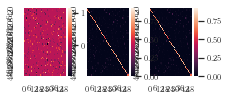

In [36]:
fig, axs = plt.subplots(1, 3)

# TODO: Plot the input weights
sns.heatmap(load("../sequential_search_fsdd_kmeans.joblib").best_estimator_.node_to_node.recurrent_weights.todense(), ax=axs[0])
sns.heatmap(load("../sequential_search_fsdd_kmeans_rec.joblib").best_estimator_.node_to_node.recurrent_weights, ax=axs[1])
sns.heatmap(load("../sequential_search_fsdd_kmeans_rec_eigs.joblib").best_estimator_.node_to_node.recurrent_weights, ax=axs[2])
fig.set_size_inches(3.2, 1.25)
plt.savefig('recurrent_weights_fsdd.pdf', bbox_inches='tight', pad_inches=0)

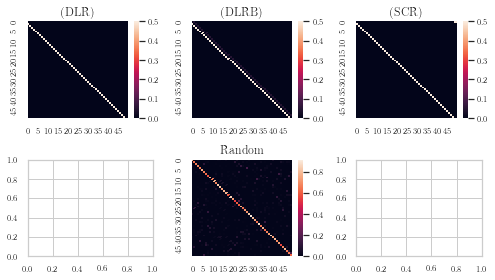

In [37]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(7, 4)

r=0.5
b=0.05

predefined_recurrent_weights_dlr = np.zeros((50, 50))
for k in range(49):
    predefined_recurrent_weights_dlr[k+1, k] = r
sns.heatmap(data=predefined_recurrent_weights_dlr, ax=axs[0][0])
axs[0][0].set_title("(DLR)")

predefined_recurrent_weights_dlrb = np.zeros((50, 50))
for k in range(49):
    predefined_recurrent_weights_dlrb[k+1, k] = r
    predefined_recurrent_weights_dlrb[k, k+1] = b
sns.heatmap(data=predefined_recurrent_weights_dlrb, ax=axs[0][1])
axs[0][1].set_title("(DLRB)")


predefined_recurrent_weights_scr = np.zeros((50, 50))
for k in range(49):
    predefined_recurrent_weights_scr[k+1, k] = r
predefined_recurrent_weights_scr[0, 49] = r
sns.heatmap(data=predefined_recurrent_weights_scr, ax=axs[0][2])
axs[0][2].set_title("(SCR)")


predefined_recurrent_weights = sequential_search.best_estimator_.node_to_node.recurrent_weights
sns.heatmap(data=predefined_recurrent_weights, ax=axs[1][1])
axs[1][1].set_title("Random")

plt.tight_layout()
plt.savefig("determinstic_weights.pdf")

# Speech commands dataset

In [53]:
training_files = pd.read_csv(r"E:\speech_commands\speech_commands_v0.01\training_list.txt", header=None, squeeze=True)
training_files = training_files[training_files.str.contains("zero|one|two|three|four|five|six|seven|eight|nine")]
validation_files = pd.read_csv(r"E:\speech_commands\speech_commands_v0.01\validation_list.txt", header=None, squeeze=True)
validation_files = validation_files[validation_files.str.contains("zero|one|two|three|four|five|six|seven|eight|nine")]
testing_files = pd.read_csv(r"E:\speech_commands\speech_commands_v0.01\testing_list.txt", header=None, squeeze=True)
testing_files = testing_files[testing_files.str.contains("zero|one|two|three|four|five|six|seven|eight|nine")]

In [54]:
scaler = StandardScaler()
X_train = np.empty(len(training_files), dtype=object)
y_train = np.empty(len(training_files), dtype=object)
X_val = np.empty(len(validation_files), dtype=object)
y_val = np.empty(len(validation_files), dtype=object)
X_test = np.empty(len(testing_files), dtype=object)
y_test = np.empty(len(testing_files), dtype=object)
from tqdm import tqdm
for k, f in tqdm(enumerate(training_files)):
    x, sr = librosa.core.load(os.path.join(r"E:\speech_commands\speech_commands_v0.01", f), sr=None, mono=False)
    mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=60, n_mfcc=13)
    X_train[k] = mfcc.T
    scaler.partial_fit(X_train[k])
    if "zero" in f:
        y_train[k] = np.atleast_1d(0).astype(int)
    elif "one" in f:
        y_train[k] = np.atleast_1d(1).astype(int)
    elif "two" in f:
        y_train[k] = np.atleast_1d(2).astype(int)
    elif "three" in f:
        y_train[k] = np.atleast_1d(3).astype(int)
    elif "four" in f:
        y_train[k] = np.atleast_1d(4).astype(int)
    elif "five" in f:
        y_train[k] = np.atleast_1d(5).astype(int)
    elif "six" in f:
        y_train[k] = np.atleast_1d(6).astype(int)
    elif "seven" in f:
        y_train[k] = np.atleast_1d(7).astype(int)
    elif "eight" in f:
        y_train[k] = np.atleast_1d(8).astype(int)
    elif "nine" in f:
        y_train[k] = np.atleast_1d(9).astype(int)
    else:
        ValueError("Unknown file {0} - cannot create a label".format(f))

18620it [00:44, 420.33it/s]


In [55]:
for k, f in tqdm(enumerate(validation_files)):
    x, sr = librosa.core.load(os.path.join(r"E:\speech_commands\speech_commands_v0.01", f), sr=None, mono=False)
    mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=60, n_mfcc=13)
    X_val[k] = mfcc.T
    if "zero" in f:
        y_val[k] = np.atleast_1d(0).astype(int)
    elif "one" in f:
        y_val[k] = np.atleast_1d(1).astype(int)
    elif "two" in f:
        y_val[k] = np.atleast_1d(2).astype(int)
    elif "three" in f:
        y_val[k] = np.atleast_1d(3).astype(int)
    elif "four" in f:
        y_val[k] = np.atleast_1d(4).astype(int)
    elif "five" in f:
        y_val[k] = np.atleast_1d(5).astype(int)
    elif "six" in f:
        y_val[k] = np.atleast_1d(6).astype(int)
    elif "seven" in f:
        y_val[k] = np.atleast_1d(7).astype(int)
    elif "eight" in f:
        y_val[k] = np.atleast_1d(8).astype(int)
    elif "nine" in f:
        y_val[k] = np.atleast_1d(9).astype(int)
    else:
        ValueError("Unknown file {0} - cannot create a label".format(f))

2494it [00:05, 487.14it/s]


In [56]:
for k, f in tqdm(enumerate(testing_files)):
    x, sr = librosa.core.load(os.path.join(r"E:\speech_commands\speech_commands_v0.01", f), sr=None, mono=False)
    mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=60, n_mfcc=13)
    X_test[k] = mfcc.T
    if "zero" in f:
        y_test[k] = np.atleast_1d(0).astype(int)
    elif "one" in f:
        y_test[k] = np.atleast_1d(1).astype(int)
    elif "two" in f:
        y_test[k] = np.atleast_1d(2).astype(int)
    elif "three" in f:
        y_val[k] = np.atleast_1d(3).astype(int)
    elif "four" in f:
        y_test[k] = np.atleast_1d(4).astype(int)
    elif "five" in f:
        y_test[k] = np.atleast_1d(5).astype(int)
    elif "six" in f:
        y_test[k] = np.atleast_1d(6).astype(int)
    elif "seven" in f:
        y_test[k] = np.atleast_1d(7).astype(int)
    elif "eight" in f:
        y_test[k] = np.atleast_1d(8).astype(int)
    elif "nine" in f:
        y_test[k] = np.atleast_1d(9).astype(int)
    else:
        ValueError("Unknown file {0} - cannot create a label".format(f))

2552it [00:04, 510.47it/s]


In [57]:
for k, X in enumerate(X_train):
    X_train[k] = scaler.transform(X)
for k, X in enumerate(X_val):
    X_val[k] = scaler.transform(X)
for k, X in enumerate(X_test):
    X_test[k] = scaler.transform(X)

In [ ]:
print(X_train.shape)

(18620,)


In [ ]:
from sklearn.model_selection import PredefinedSplit
X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))
test_fold = np.concatenate((np.zeros(len(X_train), dtype=int) - 1, np.zeros(len(X_val), dtype=int)))
ps = PredefinedSplit(test_fold)
ps.get_n_splits()
print(ps)
for train_index, test_index in ps.split():
    print("TRAIN:", train_index, "TEST:", test_index)

PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0]))
TRAIN: [    0     1     2 ... 18617 18618 18619] TEST: [18620 18621 18622 ... 21111 21112 21113]


In [ ]:
initially_fixed_params = {'hidden_layer_size': 50,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 1.0,
                          'leakage': 0.1,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bi_directional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-5,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': loguniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score), 'cv': ps}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score), 'cv': ps}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score), 'cv': ps}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3)]

base_esn = SeqToLabelESNClassifier(**initially_fixed_params)

try:
    sequential_search = load("../sequential_search_speech_command_v0.01_digits_random.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X, y)
    dump(sequential_search, "../sequential_search_speech_command_v0.01_digits_random.joblib")

Fitting 1 folds for each of 200 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 25.5min


In [ ]:
df = pd.DataFrame(sequential_search.all_cv_results_["step1"])
df["mean_test_score"] = -df["mean_test_score"]
# df.mean_test_score = df.mean_test_score.clip(upper=1.5e-1)
fig = plt.figure()
ax = sns.scatterplot(x="param_spectral_radius", y="param_input_scaling", hue="mean_test_score", palette='viridis', data=df)
plt.xlabel("Spectral Radius")
plt.ylabel("Input Scaling")

norm = plt.Normalize(-0.8, -0.1)
# sm = plt.cm.ScalarMappable(cmap="viridis")
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
plt.xlim((0, 2.01))
plt.ylim((0, 1.03))

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='DER')
fig.set_size_inches(2, 1.25)
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.grid()
# plt.savefig('optimize_is_sr_50.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
df = pd.DataFrame(sequential_search.all_cv_results_["step2"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_leakage", y="mean_test_score")
plt.xlabel("Leakage")
plt.ylabel("DER")
# plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.grid()
# plt.savefig('optimize_leakage_50.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
df = pd.DataFrame(sequential_search.all_cv_results_["step3"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score")
plt.xlabel("Bias Scaling")
plt.ylabel("DER")
plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
plt.grid()
# plt.savefig('optimize_bias_scaling_50.pdf', bbox_inches='tight', pad_inches=0)

K-Means training and transition matrix